In [1]:
%matplotlib inline
from psrqpy import QueryATNF
import os 
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import QTable, Table, Column, MaskedColumn, join

In [2]:
query = QueryATNF(checkupdate=True) #Gets the ATNF table

In [3]:
#Updated 22 May 2020 to 10-year catalog
t = Table.read('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/gll_psc_v23.fit') #Gets FERMI source catalog

In [4]:
#Clean the Fermi Table and add a corresponding PSRJ column
t = Table(t, masked=True, copy=False) 
t['PSRJ'] = ''
t['PSRJ'] = MaskedColumn(t['PSRJ'],dtype='S12')
t['PSRJ'].mask = True
for ind,source in enumerate(t):
    class1 = source['CLASS1']
    class2 = source['CLASS2']
    t['CLASS1'][ind] = class1.strip()
    t["CLASS2"][ind] = class2.strip()
    if t['CLASS1'][ind] == 'PSR' or t['CLASS1'][ind] == 'psr':
        name = source['ASSOC1']
        parts = name.split(' ')
        t['PSRJ'][ind] = parts[1]
        t['PSRJ'].mask[ind] = False
    if t["CLASS2"][ind] == 'psr': #Note that there are no CLASS2 = PSR sources
        name = source['ASSOC2']
        parts = name.split(' ')
        t['PSRJ'][ind] = parts[1]
        t['PSRJ'].mask[ind] = False

In [5]:
print(set(t['CLASS1']))

{'', 'glc', 'unk', 'gal', 'SNR', 'sey', 'nlsy1', 'bll', 'BLL', 'fsrq', 'lmb', 'BCU', 'AGN', 'NOV', 'SFR', 'hmb', 'psr', 'sfr', 'sbg', 'agn', 'PWN', 'bin', 'LMB', 'rdg', 'HMB', 'css', 'RDG', 'bcu', 'NLSY1', 'spp', 'GAL', 'pwn', 'PSR', 'BIN', 'ssrq', 'FSRQ', 'snr'}


In [6]:
print(set(t['CLASS2']))

{'', 'glc', 'bin', 'unk', 'psr', 'sey', 'sbg', 'agn'}


In [12]:
print(t[t['CLASS2'] == 'glc'])

   Source_Name     DataRelease RAJ2000  DEJ2000  ... Unc_Counterpart Flags PSRJ
                                 deg      deg    ...       deg                 
------------------ ----------- -------- -------- ... --------------- ----- ----
4FGL J1836.8-2354            1 279.2112 -23.9067 ...             nan     2   --


In [14]:
print(sum(t['PSRJ'].mask == True)) #4817 from proposal

5519


In [15]:
print(sum(t['PSRJ'].mask == False)) #248 from proposal

269


In [16]:
combined_table = join(query.table, t.filled(), keys='PSRJ',join_type='outer') #joins the tables
combined_table = Table(combined_table, masked=True, copy=False)

In [17]:
print(sum(combined_table['PSRJ'] == 'N')) #4817 from proposal

5519


In [18]:
from astropy import units as u
from astropy.coordinates import SkyCoord
combined_table['FERMIcoord'] = SkyCoord(combined_table['RAJ2000'], combined_table['DEJ2000'], unit=(u.deg, u.deg))
combined_table['ATNFcoord'] = SkyCoord(combined_table['RAJ'], combined_table['DECJ'], unit=(u.hourangle, u.deg))

In [19]:
a = np.array([combined_table['PSRJ'] == 'N'])
a = a.flatten()
print(sum(a))

5519


In [20]:
combined_table.mask['PSRJ'] = Column(a)
print(sum(combined_table.mask['PSRJ']))

5519


In [21]:
combined_table.mask['FERMIcoord'] = combined_table.mask['RAJ2000']

In [22]:
combined_table.mask['ATNFcoord'] = combined_table.mask['RAJ']

In [23]:
print(sum(combined_table.mask['FERMIcoord']))

2583


In [24]:
print(sum(combined_table.mask['ATNFcoord']))

5559


In [25]:
combined_table[np.logical_xor(combined_table.mask['ATNFcoord'],combined_table.mask['PSRJ'])]

PSRJ,PSRJ_REF,RAJ,RAJ_ERR,RAJ_REF,DECJ,DECJ_ERR,DECJ_REF,POSEPOCH,POSEPOCH_REF,F0,F0_ERR,F0_REF,F1,F1_ERR,F1_REF,PEPOCH,PEPOCH_REF,DM,DM_ERR,DM_REF,S1400,S1400_REF,DIST_DM,DIST_DM_REF,DIST_DM1,DIST_DM1_REF,TYPE,ASSOC,SURVEY,RAJD,DECJD,RAJD_ERR,DECJD_ERR,JNAME,NAME,JNAME_REF,NAME_REF,P0,P0_ERR,P0_REF,P1,P1_ERR,P1_REF,DMEPOCH,DMEPOCH_REF,S400,S400_REF,S150,S150_ERR,S150_REF,SPINDX,SPINDX_ERR,SPINDX_REF,W50,W50_REF,W10,W10_REF,F2,F2_ERR,F2_REF,F3,F3_ERR,F3_REF,NGLT,DIST_AMN,DIST_AMN_REF,DIST_AMX,DIST_AMX_REF,S300,S300_REF,PSRB,PSRB_REF,PMRA,PMRA_ERR,PMRA_REF,PMDEC,PMDEC_ERR,PMDEC_REF,RM,RM_ERR,RM_REF,S400_ERR,S600,S600_ERR,S600_REF,S1400_ERR,TAU_SC,TAU_SC_ERR,TAU_SC_REF,BNAME,BNAME_REF,ELONG,ELONG_ERR,ELONG_REF,ELAT,ELAT_ERR,ELAT_REF,PMELONG,PMELONG_ERR,PMELONG_REF,PMELAT,PMELAT_ERR,PMELAT_REF,PX,PX_ERR,PX_REF,UNITS,UNITS_REF,BINCOMP,BINARY,BINARY_REF,TASC,TASC_ERR,TASC_REF,PBDOT,PBDOT_ERR,PBDOT_REF,FB0,FB0_ERR,FB0_REF,FB2,FB2_ERR,FB2_REF,FB3,FB3_ERR,FB3_REF,A1,A1_ERR,A1_REF,EPS1,EPS1_ERR,EPS1_REF,EPS2,EPS2_ERR,EPS2_REF,CLK,CLK_REF,EPHEM,EPHEM_REF,S3000,S3000_ERR,S3000_REF,S4000,S4000_ERR,S4000_REF,S800,S800_ERR,S800_REF,S2000,S2000_ERR,S2000_REF,S900,S900_ERR,S900_REF,S1600,S1600_ERR,S1600_REF,DIST_A,DIST_A_ERR,DIST_A_REF,T0,T0_ERR,T0_REF,PB,PB_ERR,PB_REF,ECC,ECC_ERR,ECC_REF,OM,OM_ERR,OM_REF,OMDOT,OMDOT_ERR,OMDOT_REF,FB1,FB1_ERR,FB1_REF,M2,M2_ERR,M2_REF,S300_ERR,W50_ERR,S100,S100_REF,S200,S200_ERR,S200_REF,S50,S50_ERR,S50_REF,S80,S80_ERR,S80_REF,A1DOT,A1DOT_ERR,A1DOT_REF,W10_ERR,S60,S60_ERR,S60_REF,S5000,S5000_ERR,S5000_REF,DM1,DM1_ERR,DM1_REF,S100_ERR,BINCOMP_REF,S40,S40_ERR,S40_REF,TASC_2,TASC_2_ERR,TASC_2_REF,PB_2,PB_2_ERR,PB_2_REF,A1_2,A1_2_ERR,A1_2_REF,EPS1_2,EPS1_2_ERR,EPS1_2_REF,EPS2_2,EPS2_2_ERR,EPS2_2_REF,SINI,SINI_ERR,SINI_REF,M2_2,M2_2_ERR,M2_2_REF,MASS_Q,MASS_Q_ERR,MASS_Q_REF,S700,S700_ERR,S700_REF,KOM,KOM_ERR,KOM_REF,KIN,KIN_ERR,KIN_REF,H3,H3_ERR,H3_REF,STIG,STIG_ERR,STIG_REF,H4,H4_ERR,H4_REF,GAMMA,GAMMA_ERR,GAMMA_REF,DM2,DM2_ERR,DM2_REF,S100G,S100G_ERR,S100G_REF,S150G,S150G_ERR,S150G_REF,NGLT_REF,OM_ASC,OM_ASC_ERR,OM_ASC_REF,DM3,DM3_ERR,DM3_REF,T0_2,T0_2_ERR,T0_2_REF,T0_3,T0_3_ERR,T0_3_REF,PB_3,PB_3_ERR,PB_3_REF,A1_3,A1_3_ERR,A1_3_REF,ECC_2,ECC_2_ERR,ECC_2_REF,ECC_3,ECC_3_ERR,ECC_3_REF,OM_2,OM_2_ERR,OM_2_REF,OM_3,OM_3_ERR,OM_3_REF,SINI_2,SINI_2_ERR,SINI_2_REF,SINI_3,SINI_3_ERR,SINI_3_REF,M2_3,M2_3_ERR,M2_3_REF,A12DOT,A12DOT_ERR,A12DOT_REF,OM2DOT,OM2DOT_ERR,OM2DOT_REF,S6000,S6000_ERR,S6000_REF,TYPE_REF,F4,F4_ERR,F4_REF,F5,F5_ERR,F5_REF,S8000,S8000_ERR,S8000_REF,S9000,S9000_REF,S9000_ERR,ECCDOT,ECCDOT_ERR,ECCDOT_REF,DTHETA,DTHETA_ERR,DTHETA_REF,DIST,DIST1,GL,GB,XX,YY,ZZ,DMSINB,PMB,PML,AGE,BSURF,B_LC,EDOT,EDOTD2,PMTOT,PMTOT_ERR,VTRANS,P1_I,AGE_I,BSURF_I,EDOT_I,SI414,R_LUM,R_LUM14,MASSFN,MINMASS,MEDMASS,UPRMASS,MASSFN_ERR,MINOMDOT,ASSOC_ORIG,ASSOC_REF,TYPE_ORIG,BINCOMP_ORIG,Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_Index,Unc_PLEC_Index,PLEC_Expfactor,Unc_PLEC_Expfactor,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,Npred,Flux_Band [7],"Unc_Flux_Band [7,2]",nuFnu_Band [7],Sqrt_TS_Band [7],Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History [10],"Unc_Flux_History [10,2]",Sqrt_TS_History [10],ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags,FERMIcoord,ATNFcoord
,,,,,,,,d,,Hz,Hz,,1 / s2,1 / s2,,d,,pc / cm3,pc / cm3,,mJy,,kpc,,kpc,,,,,deg,deg,deg,deg,,,,,s,s,,,,,d,,mJy,,mJy,mJy,,,,,ms,,ms,,1 / s3,1 

In [26]:
globclust =  QTable.read('/Users/joshuaschroeder/Downloads/browse_results.fits')

globclust['coords'] = SkyCoord(globclust['RA'].value*u.deg, globclust['DEC'].value*u.deg)

In [27]:
distance=globclust['HELIO_DISTANCE'].value*u.kpc

In [28]:
globclust['Gamma_Ray_Hooper'] = 0.*u.erg/u.cm/u.cm/u.s

In [29]:
print(set(globclust['NAME']))

{'E 3      ', 'NGC 6325 ', 'NGC 7099 ', 'HP 1     ', 'NGC 6626 ', 'NGC 6517 ', 'PAL 3    ', 'IC 1257  ', 'NGC 5897 ', 'FSR 1735 ', 'PAL 13   ', 'PAL 1    ', 'NGC 7006 ', 'NGC 1851 ', 'NGC 6293 ', 'NGC 6544 ', 'NGC 6642 ', 'ERIDANUS ', 'NGC 6522 ', 'PAL 2    ', 'NGC 4833 ', 'NGC 6717 ', 'NGC 6205 ', 'NGC 6715 ', 'TERZAN 9 ', 'NGC 6254 ', 'NGC 6453 ', 'NGC 6352 ', 'NGC 1261 ', 'NGC 6355 ', 'NGC 6342 ', 'ESO-SC06 ', 'NGC 5024 ', 'NGC 6540 ', 'NGC 5053 ', 'NGC 6584 ', 'NGC 6864 ', 'NGC 4372 ', 'NGC 1904 ', 'NGC 6558 ', 'NGC 6496 ', 'NGC 6266 ', 'NGC 6723 ', 'RUP 106  ', 'TERZAN 10', 'NGC 6341 ', 'NGC 6101 ', 'NGC 6256 ', 'PAL 10   ', 'IC 1276  ', 'LILLER 1 ', 'NGC 2298 ', 'NGC 6638 ', 'NGC 7492 ', 'NGC 6656 ', 'NGC 6624 ', 'BH 176   ', 'NGC 6229 ', 'NGC 6934 ', 'NGC 6388 ', 'GLIMPSE01', 'NGC 6380 ', 'NGC 2808 ', 'NGC 6284 ', 'NGC 5904 ', 'NGC 4590 ', 'AM 4     ', 'UKS 1    ', 'NGC 6397 ', 'NGC 104  ', 'NGC 6528 ', 'NGC 288  ', 'NGC 5986 ', 'NGC 7078 ', 'NGC 4147 ', 'TERZAN 5 ', 'NGC 6316 '

In [30]:
print(set(globclust['ALT_NAME']))

{'HP 2       ', 'M 75       ', 'ESO456-SC38', 'M 79       ', 'M 2        ', '           ', 'M 80       ', 'M 92       ', 'ESO452-SC11', 'M 22       ', 'ESO280-SC06', 'M 9        ', 'TERZAN 11  ', 'OMEGA CEN  ', 'M 13       ', 'M 14       ', 'M 70       ', '2MASS-GC02 ', 'M 4        ', 'M 30       ', 'E 1        ', 'BH 229     ', 'DJORG 3    ', 'M 55       ', 'M 62       ', 'HP 5       ', 'BH184      ', 'AVDB       ', 'PISMIS 26  ', 'M 10       ', 'HP 3       ', 'PAL 7      ', 'M 68       ', 'M 5        ', 'M 3        ', '2MASS-GC01 ', 'TON 1      ', '47 TUC     ', 'M 69       ', 'M 12       ', 'PAL 9      ', 'M 72       ', 'M 56       ', 'HP 4       ', 'M 54       ', 'M 28       ', 'M 53       ', 'M 71       ', 'AL 3       ', 'M 19       ', 'M 107      ', 'M 15       '}


In [31]:
#Clean the Globular Cluster Table
for ind,source in enumerate(globclust):
    name = source['NAME']
    alt_name = source['ALT_NAME']
    globclust['NAME'][ind] = name.strip()
    globclust["ALT_NAME"][ind] = alt_name.strip()

In [32]:
print(set(globclust['NAME']))

{'NGC 5694', 'PAL 15', 'PAL 2', 'ERIDANUS', 'NGC 6656', 'NGC 2808', 'NGC 1261', 'NGC 6287', 'NGC 6539', 'PAL 6', 'NGC 6402', 'NGC 6864', 'NGC 6652', 'BH 176', 'NGC 6626', 'NGC 6440', 'NGC 6342', 'TERZAN 9', 'KO 2', 'NGC 6266', 'NGC 6624', 'TERZAN 2', 'NGC 6535', 'NGC 7089', 'NGC 6333', '2MS-GC02', 'NGC 6235', 'NGC 5024', 'NGC 6254', 'NGC 5272', 'NGC 6637', 'NGC 6139', 'UKS 1', 'NGC 5053', 'NGC 6293', 'TERZAN 3', 'NGC 6362', 'IC 1257', 'NGC 6284', 'NGC 6558', 'KO 1', 'NGC 6715', 'NGC 1851', 'NGC 6426', 'NGC 104', 'TERZAN 8', 'NGC 5634', 'NGC 5139', 'NGC 7078', 'TERZAN 10', 'NGC 6517', 'NGC 4590', 'TERZAN 6', 'FSR 1735', '2MS-GC01', 'NGC 6540', 'NGC 6229', 'TON 2', 'NGC 6779', 'TERZAN 1', 'NGC 6256', 'PAL 13', 'PAL 14', 'AM 4', 'GLIMPSE01', 'NGC 6218', 'NGC 5986', 'DJORG 2', 'NGC 6273', 'HP 1', 'RUP 106', 'NGC 5466', 'NGC 6541', 'NGC 6749', 'PAL 8', 'NGC 6388', 'NGC 7006', 'NGC 6341', 'PAL 4', 'TERZAN 7', 'PAL 10', 'NGC 2419', 'NGC 6838', 'NGC 4147', 'NGC 6528', 'NGC 6366', 'PAL 5', 'ARP

In [33]:
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 104'] = 2.436e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 2808'] = 3.546e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 5139'] = 5.900e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 5904'] = 2.131e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6093'] = 3.986e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6139'] = 5.330e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6218'] = 2.969e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6266'] = 1.710e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6316'] = 1.091e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6342'] = 4.339e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6388'] = 1.732e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6397'] = 6.390e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'PAL 6'] = 5.489e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'TERZAN 5'] = 5.973e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6440'] = 2.392e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6441'] = 1.252e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6541'] = 3.251e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == '2MS-GC01'] = 2.476e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == '2MS-GC02'] = 8.846e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'GLIMPSE02'] = 1.630e-11*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6652'] = 4.495e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'GLIMPSE01'] = 9.020e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6717'] = 1.816e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 6752'] = 2.866e-12*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_Hooper'][globclust['NAME'] == 'NGC 7078'] = 3.160e-12*u.erg/u.cm/u.cm/u.s

In [34]:
globclust['Gamma_Ray_deMenzes'] = 0.*u.erg/u.cm/u.cm/u.s

In [35]:
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == '47 TUC'] =  25.81*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'TERZAN 5'] =  74.41*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 62'] =  16.2*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6388'] = 25.01*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'OMEGA CEN'] =  11.03*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == '2MS-GC01'] =  57.33*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6440'] =  29.66*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6316'] =  17.29*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6441'] =   17.0*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6752'] =   5.32*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6652'] =   3.5*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 80'] =   5.94*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 2808'] =   4.43*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6541'] =  4.97*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6717'] =   2.92*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'GLIMPSE01'] =  46.54*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'GLIMPSE02'] =   23.74*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6397'] =   5.5*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['NAME'] == 'NGC 6139'] =  6.73*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 12'] =   3.20*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 5'] =   2.25*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 14'] =   3.06*(10**-12)*u.erg/u.cm/u.cm/u.s
globclust['Gamma_Ray_deMenzes'][globclust['ALT_NAME'] == 'M 79'] =   1.81*(10**-12)*u.erg/u.cm/u.cm/u.s

In [36]:
globclust['Mean Estimate Flux'] = 0.*u.erg/u.cm/u.cm/u.s

for ind,item in enumerate(globclust):
    if item['Gamma_Ray_deMenzes'].value != 0:
        if item['Gamma_Ray_Hooper'].value != 0:
            globclust['Mean Estimate Flux'][ind] = np.mean([item['Gamma_Ray_deMenzes'].value,item['Gamma_Ray_Hooper'].value])*u.erg/u.cm/u.cm/u.s

In [37]:
globclust

NAME,ALT_NAME,RA,DEC,VMAG,BV_COLOR,HELIO_DISTANCE,METALLICITY,coords,Gamma_Ray_Hooper,Gamma_Ray_deMenzes,Mean Estimate Flux
,,DEGREE,DEGREE,MAG,MAG,KPC,,"deg,deg",erg / (cm2 s),erg / (cm2 s),erg / (cm2 s)
bytes9,bytes11,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
IC 4499,,225.07688,-82.21369,9.76,0.91,18.8,-1.53,"225.07688,-82.21369",0.0,0.0,0.0
E 3,,140.23779,-77.28189,11.35,0.00,8.1,-0.83,"140.23779,-77.28189",0.0,0.0,0.0
NGC 4372,,186.43917,-72.65900,7.24,1.10,5.8,-2.17,"186.43917,-72.659",0.0,0.0,0.0
NGC 6101,,246.45050,-72.20219,9.16,0.68,15.4,-1.98,"246.4505,-72.20219",0.0,0.0,0.0
NGC 104,47 TUC,6.02363,-72.08128,3.95,0.88,4.5,-0.72,"6.02363,-72.08128",2.436e-11,2.581e-11,2.5085e-11
NGC 4833,,194.89133,-70.87650,6.91,0.93,6.6,-1.85,"194.89133,-70.8765",0.0,0.0,0.0
NGC 362,,15.80942,-70.84878,6.40,0.77,8.6,-1.26,"15.80942,-70.84878",0.0,0.0,0.0
NGC 6362,,262.97913,-67.04833,7.73,0.85,7.6,-0.99,"262.97913,-67.04833",0.0,0.0,0.0


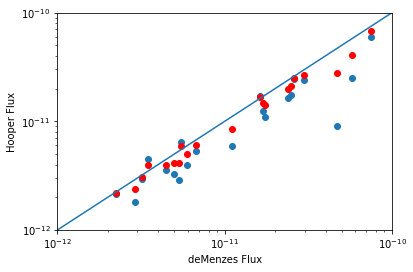

In [40]:
plt.scatter(globclust['Gamma_Ray_deMenzes'],globclust['Gamma_Ray_Hooper'])
plt.scatter(globclust['Gamma_Ray_deMenzes'],globclust['Mean Estimate Flux'],color='r')
plt.xlabel('deMenzes Flux')
plt.ylabel('Hooper Flux')
plt.xlim(1.e-12,1.e-10)
plt.ylim(1.e-12,1.e-10)
plt.xscale('log')
plt.yscale('log')
plt.plot([1e-12,1e-10],[1e-12,1e-10])

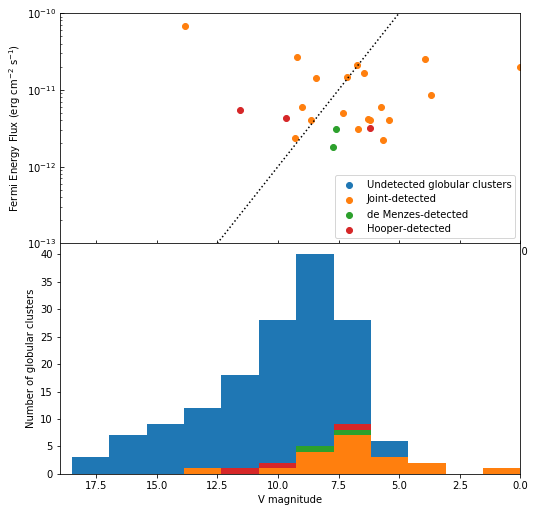

In [41]:
# the scatter plot:
#ax.scatter(x, y)

    # now determine nice limits by hand:
#    binwidth = 0.25
#    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
#    lim = (int(xymax/binwidth) + 1) * binwidth

#    bins = np.arange(-lim, lim + binwidth, binwidth)
#    ax_histx.hist(x, bins=bins)

left, width = 0.1, 0.8
bottom, height = 0.1, 0.4
spacing = 0.00


rect_histx = [left, bottom, width, height]
rect_scatter = [left, bottom + height + spacing, width, 0.4]
#rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
#scatter_hist(x, y, ax, ax_histx, )

vmags = globclust['VMAG'].value
_, bins = np.histogram(vmags, bins='auto')
a = np.logical_and([globclust['Gamma_Ray_deMenzes'].value != 0.],[globclust['Gamma_Ray_Hooper'].value != 0.])
a = a.flatten()
b = np.logical_and([globclust['Gamma_Ray_deMenzes'].value == 0.],[globclust['Gamma_Ray_Hooper'].value != 0.])
b = b.flatten()
c = np.logical_and([globclust['Gamma_Ray_deMenzes'].value != 0.],[globclust['Gamma_Ray_Hooper'].value == 0.])
c = c.flatten()
# no labels
#ax_histx.tick_params(axis="x", labelbottom=False)
#ax.ticks_position('both')
ax_histx.hist(vmags, bins=bins, label = 'Harris clusters');
ax_histx.hist([vmags[a], vmags[c], vmags[b[:]]],
         bins=bins, label = ['Joint-detected','de Menzes-detected','Hooper-detected'], stacked=True)
#ax_histx.set_xscale("log")
#ax.legend()
ax_histx.set_xlim(19,0)
#ax.set_xlabel('V magnitude')
ax.scatter(0,0,label='Undetected globular clusters')
ax.scatter(vmags[a], globclust[a]['Mean Estimate Flux'], label='Joint-detected')
ax.scatter(vmags[c], globclust[c]['Gamma_Ray_deMenzes'], label='de Menzes-detected')
ax.scatter(vmags[b], globclust[b]['Gamma_Ray_Hooper'], label='Hooper-detected')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-13, 1e-10)
ax.set_xlim(19,0)
ax_histx.set_xlabel('V magnitude')
ax_histx.set_ylabel('Number of globular clusters')
ax.set_ylabel('Fermi Energy Flux ('+r'$\rm{erg}\ \rm{cm}^{-2}\ \rm{s}^{-1}$'+')')
ax.tick_params(direction='in', which='both')
ax.plot([12.5,5],[1e-13,1e-10],':',color='black')
ax.legend()

In [42]:
print(sum(abs(180*globclust['coords'].galactic.b.radian/(np.pi)) >= 20))

49


In [43]:
print(sum(abs(180*globclust['coords'][a].galactic.b.radian/(np.pi)) >= 20))

4


In [44]:
print(sum(abs(180*globclust['coords'][b].galactic.b.radian/(np.pi)) >= 20))

1


In [45]:
print(sum(abs(180*globclust['coords'][c].galactic.b.radian/(np.pi)) >= 20))

1


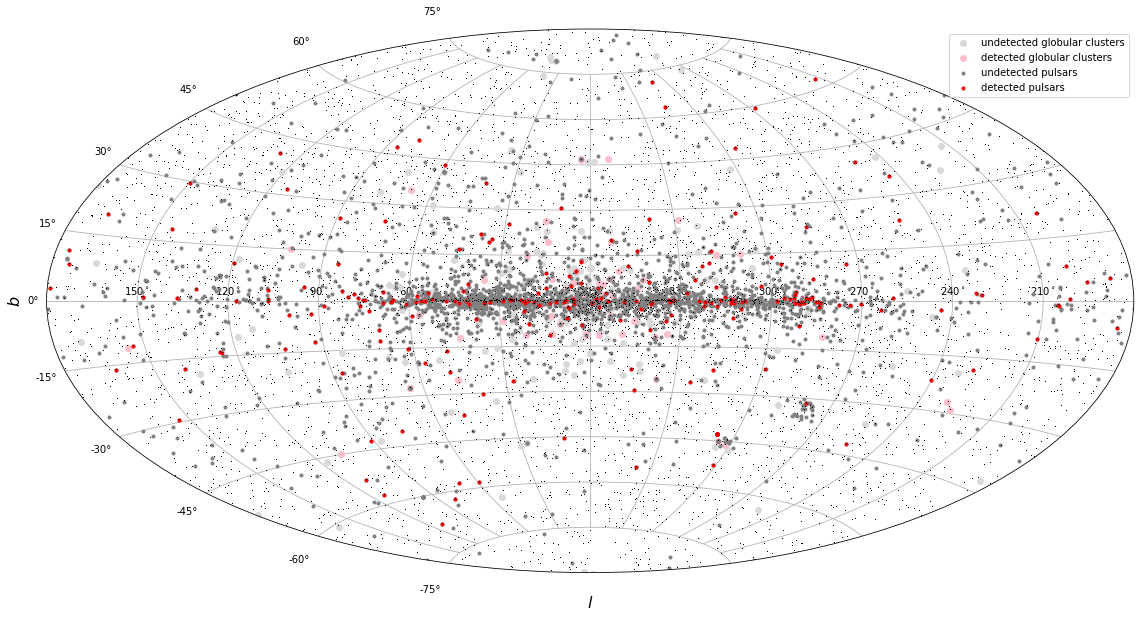

In [46]:
#Makes a scatterplot in Galactic Coordinates of all pulsars
pi = np.pi
deg2rad = pi/180.
ax = plt.figure(figsize=(20, 10))
ax = plt.subplot(111, projection='aitoff')
org=0
tick_xlabels = [r'$150^\circ$', r'$120^\circ$', r'$90^\circ$', r'$60^\circ$', r'$30^\circ$', 
                r'$0^\circ$', r'$330^\circ$', r'$300^\circ$', r'$270^\circ$', r'$240^\circ$', r'$210^\circ$']
ax.set_xticklabels(tick_xlabels)     # we add the scale on the x axis
#plt.set_xlabel(r'$l$')
#plt.xaxis.label.set_fontsize(16)
#plt.set_ylabel(r'$b$')
#plt.yaxis.label.set_fontsize(12)
ax.grid(True)
#plt.plot(x+np.pi/6,y+np.pi/6)
#plt.plot(x-np.pi/2,y-np.pi/2);

# Pass the coordinates in radians, since otherwise the
# aitoff projection messes up:
#radl = []
#radb = []
#for coord in listsky:
#    radl.append(coord.galactic.l.radian)
#    radb.append(coord.galactic.b.radian)

#radl = np.array(radl)
#radb = np.array(radb)
    
ax.plot(-1*globclust['coords'].galactic.l.radian, globclust['coords'].galactic.b.radian, 'o', color='0.85', label='undetected globular clusters')
ax.plot(2*globclust['coords'].galactic.l.radian, globclust['coords'].galactic.b.radian, 'o', color='0.85')

ax.plot(-1*globclust['coords'][a].galactic.l.radian, globclust['coords'][a].galactic.b.radian, 'o', color='pink')
ax.plot(2*globclust['coords'][a].galactic.l.radian, globclust['coords'][a].galactic.b.radian, 'o', color='pink')

ax.plot(-1*globclust['coords'][b].galactic.l.radian, globclust['coords'][b].galactic.b.radian, 'o', color='pink')
ax.plot(2*globclust['coords'][b].galactic.l.radian, globclust['coords'][b].galactic.b.radian, 'o', color='pink')

ax.plot(-1*globclust['coords'][c].galactic.l.radian, globclust['coords'][c].galactic.b.radian, 'o', color='pink')
ax.plot(2*globclust['coords'][c].galactic.l.radian, globclust['coords'][c].galactic.b.radian, 'o', color='pink')

ax.plot(-1*combined_table['FERMIcoord'][combined_table['CLASS1'] == 'glc'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['CLASS1'] == 'glc'].galactic.b.radian, 'o', color='pink', label='detected globular clusters')
ax.plot(2*pi-combined_table['FERMIcoord'][combined_table['CLASS1'] == 'glc'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['CLASS1'] == 'glc'].galactic.b.radian, 'o', color='pink')

ax.plot(-1*combined_table['FERMIcoord'][combined_table['CLASS2'] == 'glc'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['CLASS2'] == 'glc'].galactic.b.radian, 'o', color='pink')
ax.plot(2*pi-combined_table['FERMIcoord'][combined_table['CLASS2'] == 'glc'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['CLASS2'] == 'glc'].galactic.b.radian, 'o', color='pink')

ax.plot(-1*combined_table['ATNFcoord'].galactic.l.radian, combined_table['ATNFcoord'].galactic.b.radian, '.', color='gray', label='undetected pulsars')
ax.plot(2*pi-combined_table['ATNFcoord'].galactic.l.radian, combined_table['ATNFcoord'].galactic.b.radian, '.', color='gray')

ax.plot(-1*combined_table['FERMIcoord'][combined_table.mask['ATNFcoord'] == False].galactic.l.radian, combined_table['FERMIcoord'][combined_table.mask['ATNFcoord'] == False].galactic.b.radian, '.', color='red', label='detected pulsars')
ax.plot(2*pi-combined_table['FERMIcoord'][combined_table.mask['ATNFcoord'] == False].galactic.l.radian, combined_table['FERMIcoord'][combined_table.mask['ATNFcoord'] == False].galactic.b.radian, '.', color='red')

#ax.plot(-1*combined_table['FERMIcoord'][combined_table['PSRJ'] != 'N'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['PSRJ'] != 'N'].galactic.b.radian, '.', color='red', label='detected pulsars')
#ax.plot(2*pi-combined_table['FERMIcoord'][combined_table['PSRJ'] != 'N'].galactic.l.radian, combined_table['FERMIcoord'][combined_table['PSRJ'] != 'N'].galactic.b.radian, '.', color='red')

ax.plot(-1*combined_table['FERMIcoord'].galactic.l.radian, combined_table['FERMIcoord'].galactic.b.radian, ',', color='black')
ax.plot(2*pi-combined_table['FERMIcoord'].galactic.l.radian, combined_table['FERMIcoord'].galactic.b.radian, ',', color='black')


plt.grid(True)
plt.text(0,-100*deg2rad,r'$l$',
      ha='center', va='center', fontsize=16)
#plt.xlabel(r'$l$', fontsize=16)
plt.ylabel(r'$b$', fontsize=16)
plt.legend(loc='upper right')
plt.show()

In [57]:
just_pulsars = combined_table[combined_table.mask['PSRJ'] == False]
fermi_detected_pulsars = combined_table[np.logical_and(
    combined_table.mask['FERMIcoord'] == False,combined_table.mask['PSRJ'] == False)]
undetected_pulsars = combined_table[np.logical_and(
    combined_table.mask['FERMIcoord'],combined_table.mask['PSRJ'] == False)]
fermi_only_pulsars = combined_table[np.logical_xor(
    combined_table.mask['ATNFcoord'],combined_table.mask['PSRJ'])]

In [58]:
print(len(just_pulsars),len(fermi_detected_pulsars),len(undetected_pulsars),len(fermi_only_pulsars))

2852 269 2583 40


In [59]:
print(sum(abs(undetected_pulsars['ATNFcoord'].galactic.b.degree) >= 20))

443


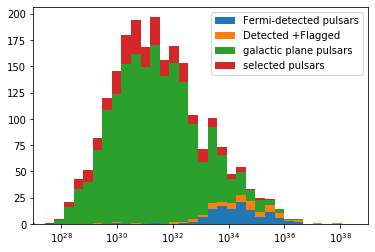

In [65]:
galactic_plane_pulsars = undetected_pulsars[abs(undetected_pulsars['ATNFcoord'].galactic.b.degree) < 20]
stack_targets = undetected_pulsars[abs(undetected_pulsars['ATNFcoord'].galactic.b.degree) >= 20]
a = np.logical_and([combined_table['Flags'] == 0],
                                                 np.logical_and(combined_table.mask['FERMIcoord'] == False, 
                                                                combined_table.mask['ATNFcoord'] == False))
a = a.flatten()
b = np.logical_and([combined_table['Flags'] != 0],
                                                 np.logical_and(combined_table.mask['FERMIcoord'] == False, 
                                                                combined_table.mask['ATNFcoord'] == False))
b = b.flatten()
fermi_detected = combined_table[a]
fermi_detected_flag = combined_table[b]
plt.hist([combined_table['EDOTD2'][a], combined_table['EDOTD2'][b],
         galactic_plane_pulsars['EDOTD2'][galactic_plane_pulsars.mask['EDOTD2'] == False],
          stack_targets['EDOTD2'][stack_targets.mask['EDOTD2'] == False]],
         bins=10**bins, label = ['Fermi-detected pulsars',
                                 'Detected +Flagged','galactic plane pulsars','selected pulsars',], stacked=True)
plt.legend()
plt.xlim(1e27,1e39)
plt.xscale('log')

In [402]:
print(bins)

[ 1.          1.34303342  1.68606684  2.02910025  2.37213367  2.71516709
  3.05820051  3.40123393  3.74426735  4.08730076  4.43033418  4.7733676
  5.11640102  5.45943444  5.80246786  6.14550127  6.48853469  6.83156811
  7.17460153  7.51763495  7.86066837  8.20370178  8.5467352   8.88976862
  9.23280204  9.57583546  9.91886887 10.26190229 10.60493571 10.94796913
 11.29100255 11.63403597 11.97706938 12.3201028  12.66313622 13.00616964
 13.34920306 13.69223648 14.03526989 14.37830331 14.72133673 15.06437015
 15.40740357 15.75043698 16.0934704  16.43650382 16.77953724 17.12257066
 17.46560408 17.80863749 18.15167091 18.49470433 18.83773775 19.18077117
 19.52380459 19.866838   20.20987142 20.55290484 20.89593826 21.23897168
 21.5820051  21.92503851 22.26807193 22.61110535 22.95413877 23.29717219
 23.6402056  23.98323902 24.32627244 24.66930586 25.01233928 25.3553727
 25.69840611 26.04143953 26.38447295 26.72750637 27.07053979 27.41357321
 27.75660662 28.09964004 28.44267346 28.78570688 29.1

In [408]:
a = np.histogram(stack_targets['EDOTD2'][stack_targets.mask['EDOTD2'] == False], bins=10**bins)
b = a[1][0:-1]
print(a[0][a[0] != 0])
print(b[a[0] != 0])

[ 1  1  4  9 11  9 12 20 27 32 18 24 15 16 17  9 12  9  7  5  5  1  2  1]
[2.59163123e+27 5.70961236e+27 1.25788240e+28 2.77123567e+28
 6.10529816e+28 1.34505578e+29 2.96328699e+29 6.52840567e+29
 1.43827043e+30 3.16864780e+30 6.98083524e+30 1.53794501e+31
 3.38824046e+31 7.46461894e+31 1.64452720e+32 3.62305126e+32
 7.98192968e+32 1.75849572e+33 3.87413485e+33 8.53509093e+33
 1.88036245e+34 4.14261896e+34 9.12658718e+34 2.01067475e+35]


In [409]:
print(10**35.64637524)

4.429709437179372e+35


In [339]:
print(sum(stack_targets['EDOTD2'][stack_targets.mask['EDOTD2'] == False]))

8.522825247623491e+35


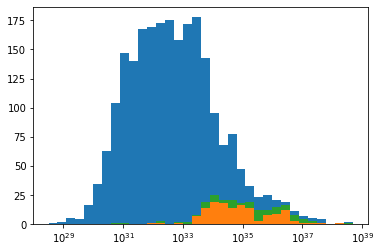

In [61]:
logs = np.log10(combined_table['EDOT'][combined_table.mask['EDOT'] == False])
_, bins = np.histogram(logs[~np.isnan(logs)], bins='auto')
a = np.logical_and([combined_table['Flags'] == 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOT'] == False))
a = a.flatten()
b = np.logical_and([combined_table['Flags'] != 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOT'] == False))
b = b.flatten()
plt.hist(combined_table['EDOT'][combined_table.mask['EDOT'] == False], bins=10**bins)
plt.hist([combined_table['EDOT'][a],combined_table['EDOT'][b]], bins=10**bins, stacked = True)
plt.xscale("log")

 

120
64


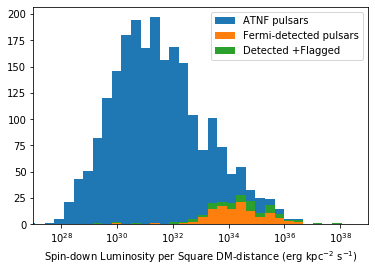

In [62]:
logs = np.log10(combined_table['EDOTD2'][combined_table.mask['EDOTD2'] == False])
_, bins = np.histogram(logs[~np.isnan(logs)], bins='auto')
a = np.logical_and([combined_table['Flags'] == 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOTD2'] == False))
a = a.flatten()
b = np.logical_and([combined_table['Flags'] != 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOTD2'] == False))
b = b.flatten()
plt.hist(combined_table['EDOTD2'][combined_table.mask['EDOTD2'] == False], bins=10**bins, label = 'ATNF pulsars');
plt.hist([combined_table['EDOTD2'][a], combined_table['EDOTD2'][b]],
         bins=10**bins, label = ['Fermi-detected pulsars','Detected +Flagged'], stacked=True)
plt.xscale("log")
plt.legend()
plt.xlim(1e27,1e39)
plt.xlabel('Spin-down Luminosity per Square DM-distance ('+r'$\rm{erg}\ \rm{kpc}^{-2}\ \rm{s}^{-1}$'+')')
print(sum(a))
print(sum(b))

NameError: name 'linregress' is not defined

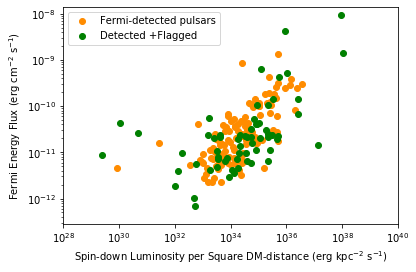

In [63]:
plt.scatter(combined_table['EDOTD2'][combined_table['Flags'] == 0], 
            combined_table['Energy_Flux100'][combined_table['Flags'] == 0], color='darkorange', 
            label='Fermi-detected pulsars')
  #           xerr=np.abs(combined_table['DIST_DM1']/combined_table['DIST_DM']-1.0)*combined_table['EDOTD2'], 
  #           yerr=combined_table['Unc_Energy_Flux100'], fmt='.', color='orange')
plt.scatter(combined_table['EDOTD2'][combined_table['Flags'] != 0], 
            combined_table['Energy_Flux100'][combined_table['Flags'] != 0], color='green',
           label='Detected +Flagged')
plt.xscale('log')
plt.yscale('log')
plt.ylim(min(combined_table['Energy_Flux100'])/1.5, max(combined_table['Energy_Flux100'])*1.5)
plt.xlim(1e28,1e40)
plt.xlabel('Spin-down Luminosity per Square DM-distance ('+r'$\rm{erg}\ \rm{kpc}^{-2}\ \rm{s}^{-1}$'+')')
plt.ylabel('Fermi Energy Flux ('+r'$\rm{erg}\ \rm{cm}^{-2}\ \rm{s}^{-1}$'+')')
plt.legend()
x = combined_table['EDOTD2'][combined_table['Flags'] == 0]
y = combined_table['Energy_Flux100'][combined_table['Flags'] == 0]
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
mask2 = x > 1e32
a = linregress(np.log10(x[x > 1e32]),np.log10(y[x > 1e32]))
plt.plot([1e0,1e40],[10**(a[1]),10**(a[1]+a[0]*40)])
print(a[1],a[0])

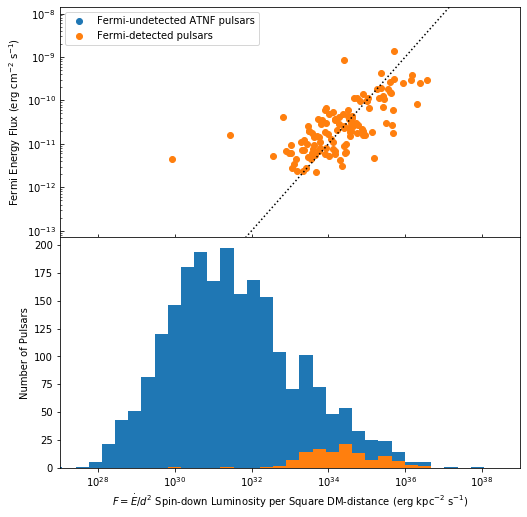

In [64]:
# the scatter plot:
#ax.scatter(x, y)

    # now determine nice limits by hand:
#    binwidth = 0.25
#    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
#    lim = (int(xymax/binwidth) + 1) * binwidth

#    bins = np.arange(-lim, lim + binwidth, binwidth)
#    ax_histx.hist(x, bins=bins)

left, width = 0.1, 0.8
bottom, height = 0.1, 0.4
spacing = 0.00


rect_histx = [left, bottom, width, height]
rect_scatter = [left, bottom + height + spacing, width, 0.4]
#rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
#scatter_hist(x, y, ax, ax_histx, )

logs = np.log10(combined_table['EDOTD2'][combined_table.mask['EDOTD2'] == False])
_, bins = np.histogram(logs[~np.isnan(logs)], bins='auto')
a = np.logical_and([combined_table['Flags'] == 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOTD2'] == False))
a = a.flatten()
b = np.logical_and([combined_table['Flags'] != 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOTD2'] == False))
b = b.flatten()
# no labels
#ax_histx.tick_params(axis="x", labelbottom=False)
#ax.ticks_position('both')
ax_histx.hist(combined_table['EDOTD2'][combined_table.mask['EDOTD2'] == False], bins=10**bins, label = 'ATNF pulsars');
#ax_histx.hist([combined_table['EDOTD2'][a], combined_table['EDOTD2'][b]],
#         bins=10**bins, label = ['Fermi-detected pulsars','Detected +Flagged'], stacked=True)
ax_histx.hist(combined_table['EDOTD2'][a],
         bins=10**bins, label = 'Fermi-detected pulsars', stacked=True)
ax_histx.set_xscale("log")
#ax.legend()
ax_histx.set_xlim(1e27,1e39)
ax.set_xlabel('Spin-down Luminosity per Square DM-distance ('+r'$\rm{erg}\ \rm{kpc}^{-2}\ \rm{s}^{-1}$'+')')
ax.scatter(0,0,label='Fermi-undetected ATNF pulsars')
ax.scatter(combined_table['EDOTD2'][combined_table['Flags'] == 0], 
            combined_table['Energy_Flux100'][combined_table['Flags'] == 0], 
            label='Fermi-detected pulsars')
  #           xerr=np.abs(combined_table['DIST_DM1']/combined_table['DIST_DM']-1.0)*combined_table['EDOTD2'], 
  #           yerr=combined_table['Unc_Energy_Flux100'], fmt='.', color='orange')
#ax.scatter(combined_table['EDOTD2'][combined_table['Flags'] != 0], 
#            combined_table['Energy_Flux100'][combined_table['Flags'] != 0],
#           label='Detected +Flagged')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(7e-14, max(combined_table['Energy_Flux100'])*1.5)
ax.set_xlim(1e27,1e39)
ax_histx.set_xlabel(r'$F = \dot{E}/d^2$'+' Spin-down Luminosity per Square DM-distance ('+r'$\rm{erg}\ \rm{kpc}^{-2}\ \rm{s}^{-1}$'+')')
ax_histx.set_ylabel('Number of Pulsars')
ax.set_ylabel('Fermi Energy Flux ('+r'$\rm{erg}\ \rm{cm}^{-2}\ \rm{s}^{-1}$'+')')
ax.tick_params(direction='in', which='both')
ax.plot([1e28,1e38],[1e-17,1e-7],':',color='black')
ax.legend()

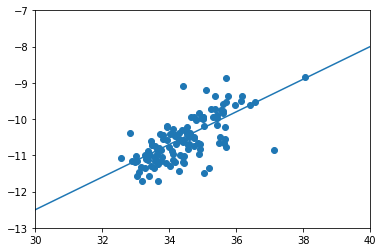

In [233]:
from scipy.optimize import curve_fit

def func(x, m, b):
    return m * x + b

x = combined_table['EDOTD2'][combined_table['Flags'] == 0]
y = combined_table['Energy_Flux100'][combined_table['Flags'] == 0]
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
plt.scatter(np.log10(x[x > 1e32]),np.log10(y[x > 1e32]))
a = linregress(np.log10(x[x > 1e32]),np.log10(y[x > 1e32]))
plt.plot([30,40],[-12.5,-8])
plt.xlim(30,40)
plt.ylim(-13,-7)
popt, pcov = curve_fit(func, np.log10(x[x > 1e32]), np.log10(y[x > 1e32]), bounds=([0.3,-50], [0.6, -15])) 


In [234]:
print(popt, pcov)


[  0.3 -15. ] [[ 9.31536284e-05 -1.90804885e-04]
 [-1.90804885e-04  3.55840537e-03]]


In [108]:
combined_table[np.logical_and(combined_table['EDOTD2'] < 1e32 , combined_table.mask['Energy_Flux100'] == False)]

PSRJ,PSRJ_REF,RAJ,RAJ_ERR,RAJ_REF,DECJ,DECJ_ERR,DECJ_REF,POSEPOCH,POSEPOCH_REF,F0,F0_ERR,F0_REF,F1,F1_ERR,F1_REF,PEPOCH,PEPOCH_REF,DM,DM_ERR,DM_REF,S1400,S1400_REF,DIST_DM,DIST_DM_REF,DIST_DM1,DIST_DM1_REF,TYPE,ASSOC,SURVEY,RAJD,DECJD,JNAME,NAME,JNAME_REF,NAME_REF,P0,P0_ERR,P0_REF,P1,P1_ERR,P1_REF,DMEPOCH,DMEPOCH_REF,S400,S400_REF,S150,S150_ERR,S150_REF,SPINDX,SPINDX_ERR,SPINDX_REF,W50,W50_REF,W10,W10_REF,F2,F2_ERR,F2_REF,F3,F3_ERR,F3_REF,NGLT,DIST_AMN,DIST_AMN_REF,DIST_AMX,DIST_AMX_REF,S300,S300_REF,PSRB,PSRB_REF,PMRA,PMRA_ERR,PMRA_REF,PMDEC,PMDEC_ERR,PMDEC_REF,RM,RM_ERR,RM_REF,S400_ERR,S600,S600_ERR,S600_REF,S1400_ERR,TAU_SC,TAU_SC_ERR,TAU_SC_REF,BNAME,BNAME_REF,ELONG,ELONG_ERR,ELONG_REF,ELAT,ELAT_ERR,ELAT_REF,PMELONG,PMELONG_ERR,PMELONG_REF,PMELAT,PMELAT_ERR,PMELAT_REF,PX,PX_ERR,PX_REF,UNITS,UNITS_REF,BINCOMP,BINARY,BINARY_REF,TASC,TASC_ERR,TASC_REF,PBDOT,PBDOT_ERR,PBDOT_REF,FB0,FB0_ERR,FB0_REF,FB2,FB2_ERR,FB2_REF,FB3,FB3_ERR,FB3_REF,A1,A1_ERR,A1_REF,EPS1,EPS1_ERR,EPS1_REF,EPS2,EPS2_ERR,EPS2_REF,CLK,CLK_REF,EPHEM,EPHEM_REF,DIST_A,DIST_A_ERR,DIST_A_REF,T0,T0_ERR,T0_REF,PB,PB_ERR,PB_REF,ECC,ECC_ERR,ECC_REF,OM,OM_ERR,OM_REF,OMDOT,OMDOT_ERR,OMDOT_REF,FB1,FB1_ERR,FB1_REF,M2,M2_ERR,M2_REF,S300_ERR,W50_ERR,S100,S100_REF,S200,S200_ERR,S200_REF,S1600,S1600_ERR,S1600_REF,S50,S50_ERR,S50_REF,S80,S80_ERR,S80_REF,S800,S800_ERR,S800_REF,A1DOT,A1DOT_ERR,A1DOT_REF,W10_ERR,S900,S900_REF,S900_ERR,S60,S60_ERR,S60_REF,S5000,S5000_ERR,S5000_REF,DM1,DM1_ERR,DM1_REF,S100_ERR,BINCOMP_REF,S40,S40_ERR,S40_REF,TASC_2,TASC_2_ERR,TASC_2_REF,PB_2,PB_2_ERR,PB_2_REF,A1_2,A1_2_ERR,A1_2_REF,EPS1_2,EPS1_2_ERR,EPS1_2_REF,EPS2_2,EPS2_2_ERR,EPS2_2_REF,SINI,SINI_ERR,SINI_REF,M2_2,M2_2_ERR,M2_2_REF,MASS_Q,MASS_Q_ERR,MASS_Q_REF,S3000,S3000_ERR,S3000_REF,S700,S700_ERR,S700_REF,KOM,KOM_ERR,KOM_REF,KIN,KIN_ERR,KIN_REF,H3,H3_ERR,H3_REF,STIG,STIG_ERR,STIG_REF,H4,H4_ERR,H4_REF,GAMMA,GAMMA_ERR,GAMMA_REF,S2000,S2000_ERR,S2000_REF,DM2,DM2_ERR,DM2_REF,S100G,S100G_ERR,S100G_REF,S150G,S150G_ERR,S150G_REF,OM_ASC,OM_ASC_ERR,OM_ASC_REF,DM3,DM3_ERR,DM3_REF,T0_2,T0_2_ERR,T0_2_REF,T0_3,T0_3_ERR,T0_3_REF,PB_3,PB_3_ERR,PB_3_REF,A1_3,A1_3_ERR,A1_3_REF,ECC_2,ECC_2_ERR,ECC_2_REF,ECC_3,ECC_3_ERR,ECC_3_REF,OM_2,OM_2_ERR,OM_2_REF,OM_3,OM_3_ERR,OM_3_REF,SINI_2,SINI_2_ERR,SINI_2_REF,SINI_3,SINI_3_ERR,SINI_3_REF,M2_3,M2_3_ERR,M2_3_REF,A12DOT,A12DOT_ERR,A12DOT_REF,OM2DOT,OM2DOT_ERR,OM2DOT_REF,S6000,S6000_ERR,S6000_REF,TYPE_REF,FB,FB_ERR,FB_REF,F4,F4_ERR,F4_REF,F5,F5_ERR,F5_REF,S8000,S8000_ERR,S8000_REF,S9000,S9000_REF,S4000,S4000_REF,PMEPOCH,PMEPOCH_REF,S9000_ERR,ECCDOT,ECCDOT_ERR,ECCDOT_REF,DTHETA,DTHETA_ERR,DTHETA_REF,DIST,DIST1,GL,GB,XX,YY,ZZ,DMSINB,PMB,PML,AGE,BSURF,B_LC,EDOT,EDOTD2,PMTOT,PMTOT_ERR,VTRANS,P1_I,AGE_I,BSURF_I,EDOT_I,SI414,R_LUM,R_LUM14,MASSFN,MINMASS,MEDMASS,UPRMASS,MASSFN_ERR,MINOMDOT,ASSOC_ORIG,ASSOC_REF,TYPE_ORIG,BINCOMP_ORIG,Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_Index,Unc_PLEC_Index,PLEC_Expfactor,Unc_PLEC_Expfactor,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,Npred,Flux_Band [7],"Unc_Flux_Band [7,2]",nuFnu_Band [7],Sqrt_TS_Band [7],Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History [8],"Unc_Flux_History [8,2]",Sqrt_TS_History [8],Variability2_Index,Frac2_Variability,Unc_Frac2_Variability,Signif2_Peak,Flux2_Peak,Unc_Flux2_Peak,Time2_Peak,Peak2_Interval,Flux2_History [48],"Unc_Flux2_History [48,2]",Sqrt_TS2_History [48],ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_C

In [134]:
a = SkyCoord(combined_table['RAJ2000'], combined_table['DEJ2000'], unit=(u.deg, u.deg))
a = [0]
for ind, things in enumerate(combined_table):
    a.append(SkyCoord(combined_table['RAJ2000'][ind], combined_table['DEJ2000'][ind], unit=(u.deg, u.deg)))

In [138]:
combined_table['FERMIcoord'] = a[1:]

In [153]:
print(combined_table['DEJ2000'].mask[1])

True


In [56]:
print(len(query.table))

2800


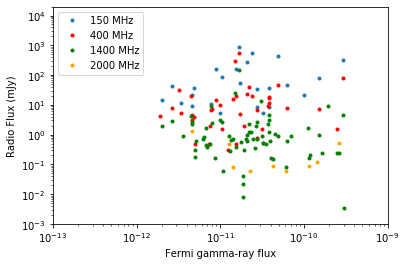

In [426]:
plt.plot(combined_table['Energy_Flux100'][combined_table['Flags'] == 0], combined_table['S150'][combined_table['Flags'] == 0],'.',label='150 MHz')
plt.plot(combined_table['Energy_Flux100'][combined_table['Flags'] == 0], combined_table['S400'][combined_table['Flags'] == 0],'.',color='red', label='400 MHz')
plt.plot(combined_table['Energy_Flux100'][combined_table['Flags'] == 0], combined_table['S1400'][combined_table['Flags'] == 0],'.',color='green', label = '1400 MHz')
plt.plot(combined_table['Energy_Flux100'][combined_table['Flags'] == 0], combined_table['S2000'][combined_table['Flags'] == 0],'.',color='orange', label = '2000 MHz')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,2e4)
plt.xlim(1e-13,1e-9)
plt.xlabel('Fermi gamma-ray flux')
plt.ylabel('Radio Flux (mJy)')
plt.legend()

In [66]:
print(np.min(combined_table['S400'][combined_table['S400'] > 0]))

0.13


Text(0, 0.5, 'Fermi Energy Flux ($\\rm{erg}\\ \\rm{cm}^{-2}\\ \\rm{s}^{-1}$)')

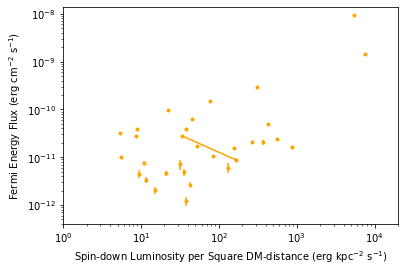

In [113]:
plt.errorbar(combined_table['S150'], combined_table['Energy_Flux100'], yerr=combined_table['Unc_Energy_Flux100'], marker='.', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,2e4)
plt.ylim(min(combined_table['Energy_Flux100'])/1.5, max(combined_table['Energy_Flux100'])*1.5)
plt.xlabel('Spin-down Luminosity per Square DM-distance ('+r'$\rm{erg}\ \rm{kpc}^{-2}\ \rm{s}^{-1}$'+')')
plt.ylabel('Fermi Energy Flux ('+r'$\rm{erg}\ \rm{cm}^{-2}\ \rm{s}^{-1}$'+')')

In [145]:
a = np.logical_and([combined_table['Flags'] == 0],
                                                 np.logical_and(combined_table.mask['DEJ2000'] == False, 
                                                                combined_table.mask['EDOTD2'] == False))
print (a.flatten())

[ True False  True ... False False False]


In [270]:
combined_table.mask['FERMIcoord'] = combined_table.mask['RAJ2000']

In [276]:
print(just_pulsars)

    PSRJ    PSRJ_REF ...               ATNFcoord               
                     ...                deg,deg                
----------- -------- ... --------------------------------------
 J0002+6216   cwp+17 ...             0.742375,62.26927777777777
 J0006+1834    cnt96 ...                1.52,18.583055555555557
 J0007+7303  aaa+09c ...    1.757083333333333,73.05205555555555
   J0011+08   dsm+16 ...    2.891666666666666,8.166666666666666
 J0014+4746       -- ...   3.5739583333333327,47.77594444444444
 J0023+0923   hrm+11 ...    5.820321666666667,9.389967166666667
J0024-7204C       -- ...           5.959810833333333,-72.075418
J0024-7204D       -- ...   6.057837166666666,-72.07884788888889
J0024-7204E       -- ...   6.046271999999999,-72.08893033333332
J0024-7204F       -- ...   6.016064458333333,-72.07856063888889
        ...      ... ...                                    ...
 J2339-0533   rbs+14 ... 354.91141666666664,-5.5514777777777775
   J2340+08   dsm+13 ...                

In [277]:
print(combined_table)

    PSRJ    PSRJ_REF ...              ATNFcoord              
                     ...               deg,deg               
----------- -------- ... ------------------------------------
 J0002+6216   cwp+17 ...           0.742375,62.26927777777777
 J0006+1834    cnt96 ...              1.52,18.583055555555557
 J0007+7303  aaa+09c ...  1.757083333333333,73.05205555555555
   J0011+08   dsm+16 ...  2.891666666666666,8.166666666666666
 J0014+4746       -- ... 3.5739583333333327,47.77594444444444
 J0023+0923   hrm+11 ...  5.820321666666667,9.389967166666667
J0024-7204C       -- ...         5.959810833333333,-72.075418
J0024-7204D       -- ... 6.057837166666666,-72.07884788888889
J0024-7204E       -- ... 6.046271999999999,-72.08893033333332
J0024-7204F       -- ... 6.016064458333333,-72.07856063888889
        ...      ... ...                                  ...
         --       -- ...                              0.0,0.0
         --       -- ...                              0.0,0.0
        

In [278]:
print(combined_table.mask['FERMIcoord'])

FERMIcoord
----------
     False
      True
     False
      True
      True
     False
      True
      True
      True
      True
       ...
     False
     False
     False
     False
     False
     False
     False
     False
     False
     False
     False
Length = 7640 rows


In [282]:
print(just_pulsars.mask['FERMIcoord'])

FERMIcoord
----------
     False
      True
     False
      True
      True
     False
      True
      True
      True
      True
       ...
      True
     False
      True
      True
      True
      True
      True
      True
      True
      True
      True
Length = 2800 rows


In [341]:
pulsar_bright = combined_table[combined_table['EDOTD2'] > 8.522825247623491e+35]
print(pulsar_bright['PSRJ'],pulsar_bright['EDOTD2'])

   PSRJ   
----------
J0205+6449
J0534+2200
J0633+1746
J0835-4510
J0940-5428
J1023-5746
J1057-5226
J1400-6325
J1418-6058
J1513-5908
J1813-1246
J1813-1749
J1826-1256
J1833-1034
J2021+3651
J2229+6114         EDOTD2        
    erg / (kpc2 s)    
----------------------
2.6320800069679393e+36
1.1158586159746266e+38
 9.001236565495479e+35
 8.831049393044116e+37
1.3392840173604669e+37
2.5280055991013754e+36
 3.715641406939203e+36
1.0337559537468309e+36
1.3921567898632198e+36
 9.025373519137203e+35
 8.989402213678389e+35
2.5322525816028052e+36
1.4902909131813388e+36
2.0019253050981457e+36
1.0446502195008574e+36
2.4955619654086876e+36
